In [22]:
import numpy as np
import pandas as pd
from sklearn import metrics, manifold
from tqdm import tqdm
import gensim.downloader as gensim_api
import transformers
import os
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('output1.csv',nrows=4000)
print(df["clean"])

0        rt mleew boy dats cold tyga dwn bad for cuffi...
1        rt urkindofbrand dawg rt sbaby life you ever ...
2        rt c g anderson viva based she look like a tr...
3        rt shenikaroberts the shit you hear about me ...
4        t madison x the shit just blows me claim you ...
                              ...                        
3995            msoltan koredeb the witches took them hoe
3996     msoltan matt simonson koredeb nvm thought we ...
3997     mtbornnard it s got good mojo for sure paybac...
3998     m a larson stevestreza you re saying zebras a...
3999                              m carbonaro nice pussy 
Name: clean, Length: 4000, dtype: object


In [3]:
nlp = gensim_api.load("glove-wiki-gigaword-300")

In [4]:
nlp.most_similar(["nigger"], topn=3)

[('slur', 0.5023007392883301),
 ('niggers', 0.5003144145011902),
 ('faggot', 0.4708784222602844)]

In [5]:
def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))

In [6]:
def similarWords(words, top, nlp):
    out = words
    for tupl in nlp.most_similar(words, topn=top):
        out.append(tupl[0])
    return list(set(out))

In [7]:
clusters={}
clusters['HATE']=get_similar_words(['hate'], top=30, nlp=nlp)

In [8]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('al', do_lower_case=True)
nlp = transformers.TFDistilBertModel.from_pretrained('al')

Some layers from the model checkpoint at al were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at al.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [9]:
def utils_bert_embedding(txt, tokenizer, nlp):
    '''
    Word embedding with Bert (equivalent to nlp["word"]).
    :parameter
        :param txt: string 
        :param tokenizer: transformers tokenizer
        :param nlp: transformers bert
    :return
        tensor sentences x words x vector (1x3x768) 
    '''
    # tokenize sentence to tokens (integers)
    idx = tokenizer.encode(txt)
    # convert to array of shape (1, num_words+2) - EOS and CLS added
    idx = np.array(idx)[None,:]
    # generate embeddings for each token - output is a tuple
    embedding = nlp(idx)
    # select first member of the tuple, remove first dimension which is 1 to get (num_words,embedding size 712)
    # exclude CLS and EOS tokens
    X = np.array(embedding[0][0][1:-1])
    return X

In [10]:
%%time
## create list of news vector
lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) for txt in tqdm(df["clean"])]

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [15:15<00:00,  4.37it/s]

Wall time: 15min 15s


In [11]:
X = np.array(lst_mean_vecs)
X.shape

(4000, 768)

In [12]:
np.savetxt("mean_vec.csv", X, delimiter="/")

In [13]:
print(X)

[[-2.56808370e-01  2.32406840e-01  1.69656605e-01 ... -8.87778848e-02
   1.40191754e-02  1.45572618e-01]
 [ 8.45624730e-02  3.25855941e-01  4.16700900e-01 ... -1.73627079e-01
   2.83790618e-01 -5.14129251e-02]
 [ 2.25455880e-01 -2.60253102e-01  3.21632028e-01 ... -3.30394179e-01
   1.92198440e-01  1.67761743e-01]
 ...
 [ 1.43120185e-01  1.55305579e-01  3.58505338e-01 ... -1.13864124e-01
   1.88397214e-01 -3.04630812e-04]
 [ 9.60611254e-02  8.89073536e-02  2.41476282e-01 ...  4.43981290e-02
   1.34531409e-01  1.73412785e-01]
 [ 8.62215906e-02 -2.67725110e-01  4.67932045e-01 ...  6.54157391e-03
  -4.68252897e-02  1.25600457e-01]]


In [14]:
from numpy import genfromtxt
my_data = genfromtxt('mean_vec.csv', delimiter='/')
print(my_data)

[[-2.56808370e-01  2.32406840e-01  1.69656605e-01 ... -8.87778848e-02
   1.40191754e-02  1.45572618e-01]
 [ 8.45624730e-02  3.25855941e-01  4.16700900e-01 ... -1.73627079e-01
   2.83790618e-01 -5.14129251e-02]
 [ 2.25455880e-01 -2.60253102e-01  3.21632028e-01 ... -3.30394179e-01
   1.92198440e-01  1.67761743e-01]
 ...
 [ 1.43120185e-01  1.55305579e-01  3.58505338e-01 ... -1.13864124e-01
   1.88397214e-01 -3.04630812e-04]
 [ 9.60611254e-02  8.89073536e-02  2.41476282e-01 ...  4.43981290e-02
   1.34531409e-01  1.73412785e-01]
 [ 8.62215906e-02 -2.67725110e-01  4.67932045e-01 ...  6.54157391e-03
  -4.68252897e-02  1.25600457e-01]]


In [15]:
dic_y = {k:utils_bert_embedding(v, tokenizer, nlp).mean(0) for k,v in tqdm(clusters.items())}

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


In [16]:
print(dic_y.values())

dict_values([array([ 2.53705651e-01,  2.00686127e-01,  1.13013640e-01, -2.78772235e-01,
       -3.89851406e-02, -1.97280705e-01,  5.36987424e-01,  2.47883216e-01,
       -1.66301895e-02, -2.60325402e-01,  1.39833346e-01, -2.47734636e-01,
       -2.17199594e-01,  1.09143760e-02,  5.52281514e-02,  5.93813732e-02,
        8.37251469e-02,  1.56362236e-01, -1.90861642e-01,  5.56159973e-01,
        1.59280896e-01,  1.94304600e-01, -1.28588274e-01, -3.84311490e-02,
        1.99816599e-01,  3.47130239e-01,  4.82159019e-01, -2.54657030e-01,
       -2.07983926e-01, -2.28204906e-01,  6.39776051e-01,  1.69228092e-01,
        9.33268815e-02,  1.02556892e-01, -9.72913727e-02,  1.04299232e-01,
        3.43436636e-02,  2.09560081e-01,  1.58253461e-01,  2.35363394e-01,
       -4.60688561e-01, -3.55075419e-01,  4.83657196e-02,  3.18932861e-01,
       -3.77309978e-01, -4.21153814e-01, -3.12134206e-01,  1.40632719e-01,
        1.70946091e-01, -2.40436107e-01, -4.38368283e-02,  2.16800869e-01,
       -1.49

In [17]:
similarities = np.array(
            [metrics.pairwise.cosine_similarity(X, [dic_y['HATE']]).T.tolist()[0]]
            ).T

In [18]:
print(similarities)

[[0.61130393]
 [0.73238176]
 [0.67944461]
 ...
 [0.64469039]
 [0.68099171]
 [0.5732342 ]]


In [29]:
labels=list(dic_y.keys())
similarities[0]=similarities[0]/sum(similarities[0])

[[1.        ]
 [0.73238176]
 [0.67944461]
 ...
 [0.64469039]
 [0.68099171]
 [0.5732342 ]]


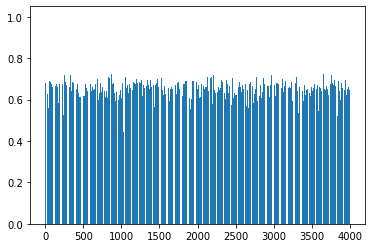

In [32]:
y=[]
for similarity in similarities:
    y.append(similarity[0])

x=np.arange(df.shape[0])
plt.bar(x,height=y)
plt.show()